In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load Dataset
df = pd.read_csv("exchange_rate.csv")
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["date"]

0      1990-01-01
1      1990-02-01
2      1990-03-01
3      1990-04-01
4      1990-05-01
          ...    
7583   2010-06-10
7584   2010-07-10
7585   2010-08-10
7586   2010-09-10
7587   2010-10-10
Name: date, Length: 7588, dtype: datetime64[ns]

In [4]:
# Sort by date
df = df.sort_values("date")
df

,date,Ex_rate
0,1990-01-01,0.785500
31,1990-01-02,0.750000
59,1990-01-03,0.747100
90,1990-01-04,0.758700
120,1990-01-05,0.785200
...,...,...
7573,NaT,0.729714
7574,NaT,0.726533
7575,NaT,0.725058
7576,NaT,0.724506


In [5]:
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
31,1990-01-02,0.7500
59,1990-01-03,0.7471
90,1990-01-04,0.7587
120,1990-01-05,0.7852


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 0 to 7577
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2998 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 177.8 KB


In [7]:
df.columns

Index(['date', 'Ex_rate'], dtype='object')

In [8]:
df.isnull().sum()

date       4590
Ex_rate       0
dtype: int64

In [9]:
df.describe()

,date,Ex_rate
count,2998,7588.000000
mean,2000-05-20 18:14:10.166777728,0.776974
min,1990-01-01 00:00:00,0.483297
25%,1995-03-06 06:00:00,0.701422
50%,2000-05-11 12:00:00,0.761377
75%,2005-08-04 18:00:00,0.873477
max,2010-12-09 00:00:00,1.102536
std,NaN,0.136620


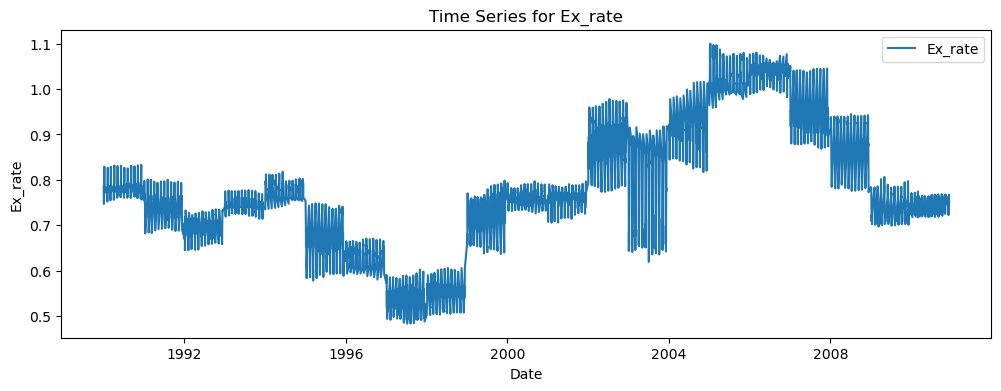

In [10]:
#Visualization
def plot_time_series(df, col):
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df[col], label=col)
    plt.title(f'Time Series for {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.show()
plot_time_series(df,"Ex_rate")

In [11]:
#Handle Missing Values
df = df.fillna(method="ffill")
df

,date,Ex_rate
0,1990-01-01,0.785500
31,1990-01-02,0.750000
59,1990-01-03,0.747100
90,1990-01-04,0.758700
120,1990-01-05,0.785200
...,...,...
7573,2010-12-09,0.729714
7574,2010-12-09,0.726533
7575,2010-12-09,0.725058
7576,2010-12-09,0.724506


In [12]:
#Check Stationarity
result = adfuller(df["Ex_rate"])
print("ADF Test Results:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Test Results:
ADF Statistic: -2.4371548684089666
p-value: 0.1315230826951877


In [13]:
if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is NOT stationary, differencing needed.")

The series is NOT stationary, differencing needed.


In [14]:
#Train test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [15]:
#Exponential Smoothing
ets_model = ExponentialSmoothing(train["Ex_rate"], trend="add", seasonal=None).fit()
ets_pred = ets_model.forecast(len(test))

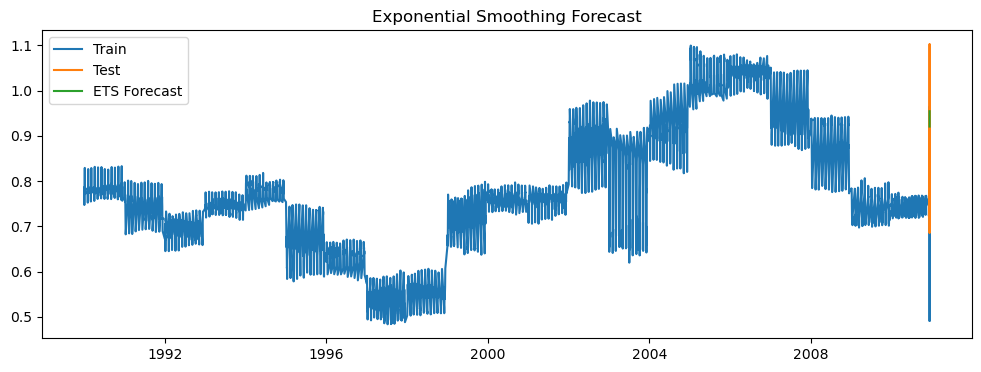

In [16]:
##Visualization
#Exponential Smoothing Forecast
plt.figure(figsize=(12,4))
plt.plot(train["date"], train["Ex_rate"], label="Train")
plt.plot(test["date"], test["Ex_rate"], label="Test")
plt.plot(test["date"], ets_pred, label="ETS Forecast")
plt.legend()
plt.title("Exponential Smoothing Forecast")
plt.show()

In [17]:
#ARIMA Model
arima_model = ARIMA(train["Ex_rate"], order=(1,1,1)).fit()
arima_pred = arima_model.forecast(len(test))

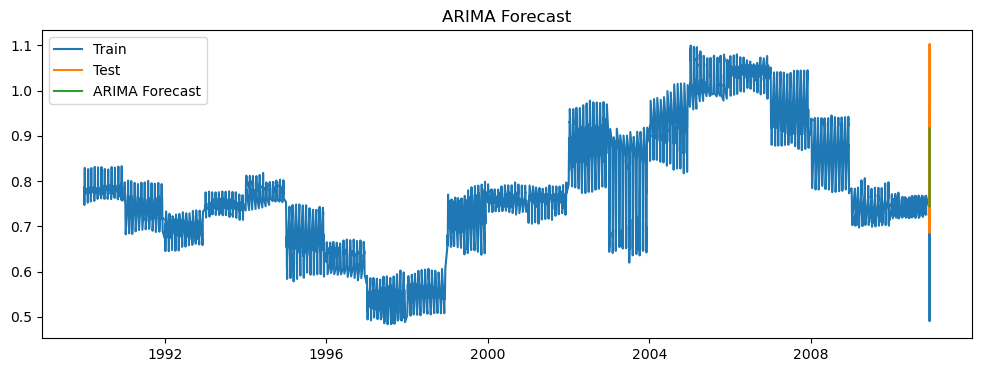

In [18]:
#ARIMA Forecast
plt.figure(figsize=(12,4))
plt.plot(train["date"], train["Ex_rate"], label="Train")
plt.plot(test["date"], test["Ex_rate"], label="Test")
plt.plot(test["date"], arima_pred, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

In [19]:
#Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
ets_rmse = np.sqrt(mean_squared_error(test["Ex_rate"], ets_pred))
arima_rmse = np.sqrt(mean_squared_error(test["Ex_rate"], arima_pred))

In [20]:
ets_mae = mean_absolute_error(test["Ex_rate"], ets_pred)
arima_mae = mean_absolute_error(test["Ex_rate"], arima_pred)

In [21]:
print("Model Evaluation")
print(f"ETS -> RMSE: {ets_rmse:.4f}, MAE: {ets_mae:.4f}")
print(f"ARIMA -> RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}")

Model Evaluation
ETS -> RMSE: 0.1270, MAE: 0.1029
ARIMA -> RMSE: 0.1925, MAE: 0.1590


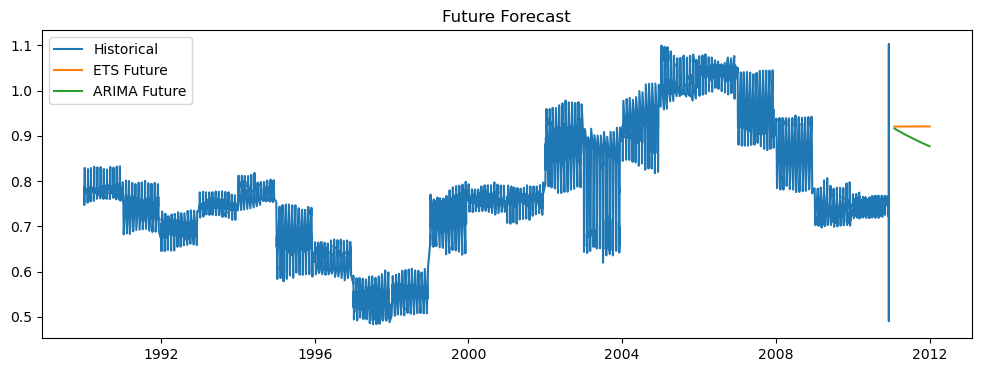

In [22]:
#Forecast Future
future_steps = 12
ets_future = ets_model.forecast(future_steps)
arima_future = arima_model.forecast(future_steps)

plt.figure(figsize=(12,4))
plt.plot(df["date"], df["Ex_rate"], label="Historical")
plt.plot(pd.date_range(df["date"].iloc[-1], periods=future_steps+1, freq="M")[1:], ets_future, label="ETS Future")
plt.plot(pd.date_range(df["date"].iloc[-1], periods=future_steps+1, freq="M")[1:], arima_future, label="ARIMA Future")
plt.legend()
plt.title("Future Forecast")
plt.show()

In [23]:
#Conclusion
#“The dataset shows fluctuations in exchange rates, and time series models like ARIMA/ETS can be used for accurate forecasting.”

In [24]:
#### Thanks you####